**Step 1: Setup and Install Libraries**

In [25]:
!pip install matplotlib seaborn scikit-learn opencv-python-headless


**Step 2: Import Libraries**


In [27]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
import joblib

**Step 3: Load the Dataset**

In [28]:
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

dataset_zip_path = '/content/drive/MyDrive/Dataset/MangoLeafBD.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 4: Extract the Zip File**

In [29]:
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/mango_leaf_dataset')


**Step 5: Load and Preprocess Images**

In [30]:
# Set the directory where the dataset is located
data_dir = '/content/mango_leaf_dataset'

# Initialize lists to store image data and labels
images = []
labels = []

# Define common image file extensions
valid_image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

# Walk through each directory and subdirectory in the dataset
for root, dirs, files in os.walk(data_dir):
    # Extract the folder name as the label (assumes the last directory name is the label)
    disease_label = os.path.basename(root)

    # Loop through files in the current directory
    for img_file in files:
        # Check if the file has a valid image extension
        file_ext = os.path.splitext(img_file)[1].lower()
        if file_ext in valid_image_extensions:
            img_path = os.path.join(root, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

            # Only proceed if the image was successfully read
            if img is not None:
                try:
                    # Resize all images to 128x128
                    img = cv2.resize(img, (128, 128))  # Resize to 128x128
                    img = img / 255.0  # Normalize pixel values
                    images.append(img)
                    labels.append(disease_label)  # Use folder name as label
                except Exception as e:
                    print(f"Error resizing image {img_path}: {e}")
            else:
                print(f"Warning: Could not read image {img_path}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display the shape of the loaded data for confirmation
print(f"Loaded {len(images)} images with shape {images.shape} and {len(labels)} labels.")


Loaded 4000 images with shape (4000, 128, 128) and 4000 labels.


**Step 6: Encode Labels and Split Data**

**Encode Labels:** Convert categorical labels to numeric values.

In [31]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


**Split Data** into training and testing sets.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)


**Step 7: Perform Exploratory Data Analysis (EDA)**


**Visualize Class Distribution:**



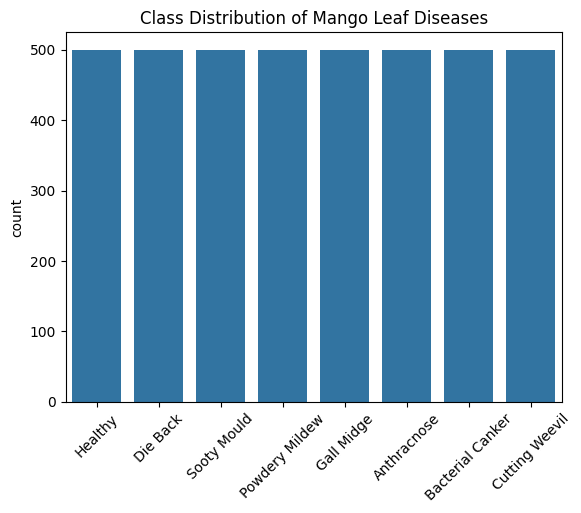

In [33]:
sns.countplot(x=labels)
plt.title("Class Distribution of Mango Leaf Diseases")
plt.xticks(rotation=45)
plt.show()


**Display Sample Images:**



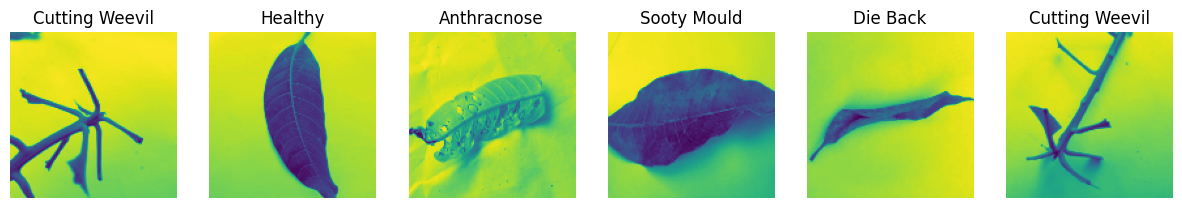

In [41]:
def plot_samples(images, labels, n=6):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        # Check if the image is in RGB format already or convert it
        if len(images[i].shape) == 3 and images[i].shape[2] == 3:  # Check for color image
            img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
        else:
            img_rgb = images[i]  # If already in RGB, use as is
        plt.imshow(img_rgb)
        plt.title(label_encoder.inverse_transform([labels[i]])[0])
        plt.axis("off")
    plt.show()

# Assuming you have the label_encoder and X_train, y_train prepared
plot_samples(X_train, y_train)


**Step 8: Flatten Images for Model Input**


In [42]:
def flatten_images(images):
    return images.reshape(len(images), -1)

X_train_flat = flatten_images(X_train)
X_test_flat = flatten_images(X_test)


**Step 9: Train Models**


**Decision Tree Classifier:**


In [43]:
# Initialize and train Decision Tree classifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_flat, y_train)


DecisionTreeClassifier(random_state=42)

**Random Forest Classifier:**



In [44]:
# Initialize and train Random Forest classifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_flat, y_train)


RandomForestClassifier(random_state=42)

**Step 10: Evaluate Models**


**Predict and Evaluate:**



In [46]:
# Decision Tree Evaluation
dt_predictions = dt_model.predict(X_test_flat)
accuracy_dt = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions, target_names=label_encoder.classes_))

# Random Forest Evaluation
rf_predictions = rf_model.predict(X_test_flat)
accuracy_rf = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))

Decision Tree Accuracy: 0.59375
Decision Tree Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.45      0.50      0.47        90
Bacterial Canker       0.55      0.58      0.57        91
  Cutting Weevil       0.92      0.91      0.92        93
        Die Back       0.67      0.77      0.72        86
      Gall Midge       0.47      0.48      0.48       104
         Healthy       0.65      0.63      0.64       123
  Powdery Mildew       0.47      0.44      0.45       101
     Sooty Mould       0.57      0.49      0.53       112

        accuracy                           0.59       800
       macro avg       0.60      0.60      0.60       800
    weighted avg       0.59      0.59      0.59       800

Random Forest Accuracy: 0.82375
Random Forest Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.70      0.81      0.75        90
Bacterial Canker       0.76      0.84      0.8

**Confusion Matrix:**


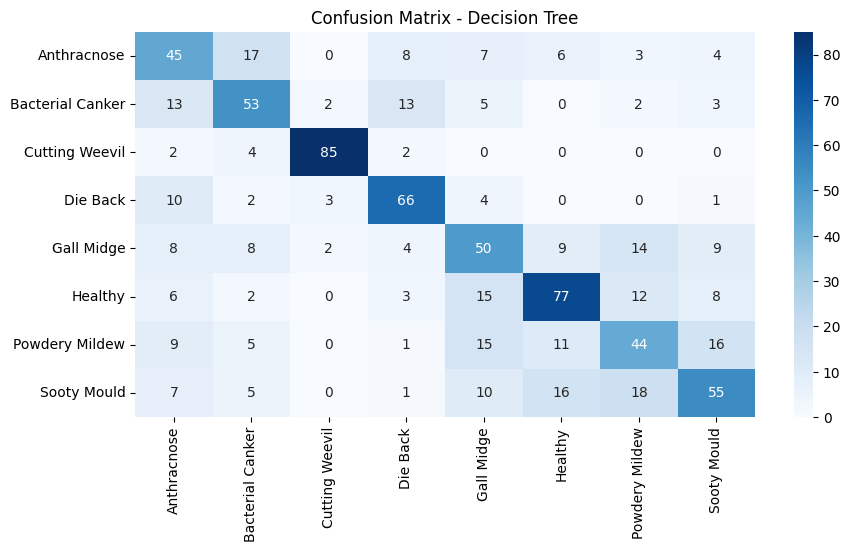

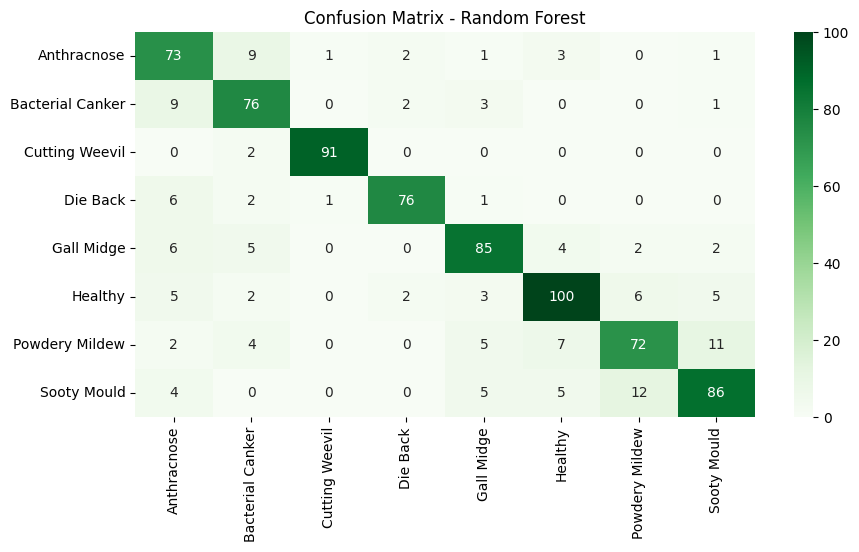

In [48]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, dt_predictions), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Step 11: Plot Learning Curve**


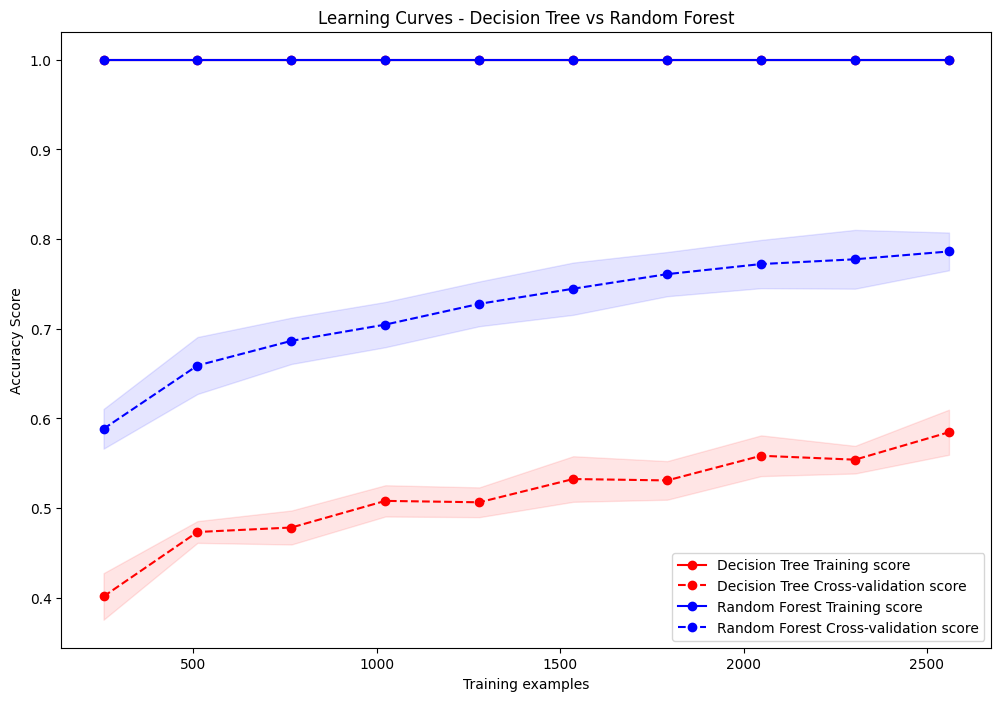

In [49]:
def plot_learning_curve(estimator, X, y, title, color):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color=color)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=color)
    plt.plot(train_sizes, train_scores_mean, 'o-', color=color, label=f"{title} Training score")
    plt.plot(train_sizes, test_scores_mean, 'o--', color=color, label=f"{title} Cross-validation score")

plt.figure(figsize=(12, 8))
plot_learning_curve(dt_model, X_train_flat, y_train, "Decision Tree", color="r")
plot_learning_curve(rf_model, X_train_flat, y_train, "Random Forest", color="b")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curves - Decision Tree vs Random Forest")
plt.legend(loc="best")
plt.show()

**Step 12: Plot ROC Curve**


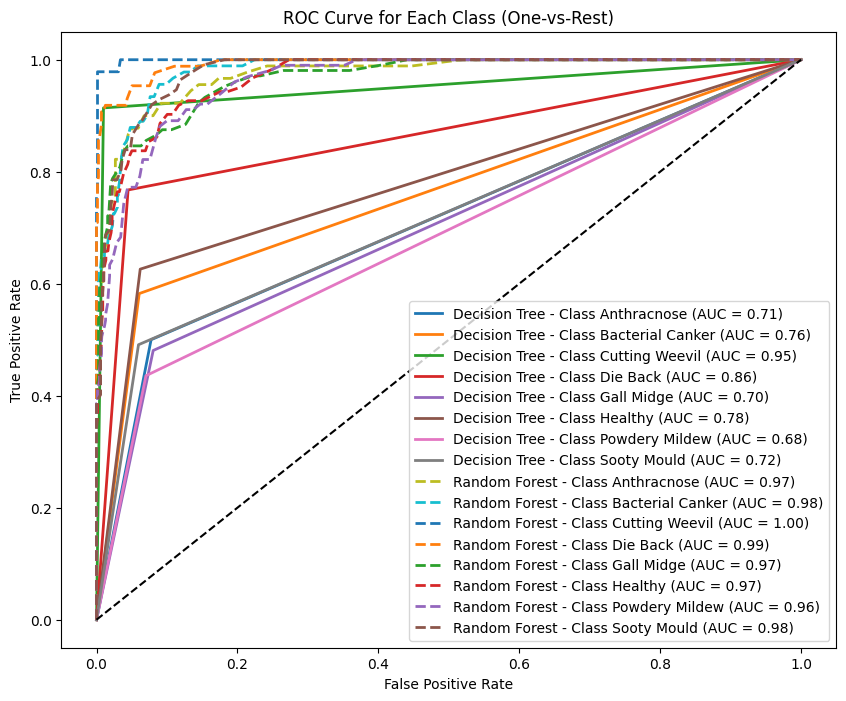

In [52]:
def plot_roc_curve(models, model_names, X_test, y_test_bin, label_encoder):
    plt.figure(figsize=(10, 8))
    for model, name in zip(models, model_names):
        for i in range(n_classes):
            proba = model.predict_proba(X_test)[:, i]
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba)
            roc_auc = auc(fpr, tpr)
            linestyle = '-' if name == 'Decision Tree' else '--'
            plt.plot(fpr, tpr, lw=2, linestyle=linestyle, label=f'{name} - Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Call function with models
plot_roc_curve([dt_model, rf_model], ['Decision Tree', 'Random Forest'], X_test_flat, y_test_bin, label_encoder)

**Optional: Save Models for Later Use**


In [53]:
joblib.dump(dt_model, 'decision_tree_model.joblib')
joblib.dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']